In [1]:
import numpy as np
import pandas as pd
import os
import const
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from arguments import parse_arg, get_question

sns.set()

In [109]:
def get_event_counts(events, event_types):
    event_counts = {t: 0 for t in event_types}
    
    for event_type, events in events.items():
        event_counts[event_type] = len(events)
    
    event_types += ['total_nodes', 'total_arrows']
    
    event_counts['total_nodes'] = event_counts['node_create'] - event_counts['node_delete']
    event_counts['total_arrows'] = event_counts['arrow_create'] - event_counts['arrow_delete']
    
    return event_counts


def load_questionnaire_responses():
    df_quest = pd.read_csv(const.QUESTIONNAIRE_RESPONSES_FILE)
    
    for cat_col in 'age gender subject role essay_freq preference'.split():
        df_quest[cat_col] = df_quest[cat_col].astype('category')
        
    df_quest['essay_freq'].cat.reorder_categories('Never Rarely Months Weeks Days'.split(), ordered=True, inplace=True)
    
    subjects = set()
    for subject_val in df_quest['subject']:
        subjects.update([s.strip() for s in subject_val.split(',')])
    
    for subject in subjects:
        df_quest[subject] = (df_quest['subject'].str.contains(subject))
    
    return df_quest, subjects
    

def make_df():
    rows = []
    
    # find all possible event types first
    event_types = set()
    for filename in os.listdir(const.DATA_DIR):
        with open(os.path.join(const.DATA_DIR, filename), 'r') as f:
            data = json.load(f)
            event_types.update(data['logs']['events'].keys())
    event_types = list(event_types)  # so it is ordered
    
    # generate all columns and rows
    for filename in os.listdir(const.DATA_DIR):
        columns = []
        row = []
        
        with open(os.path.join(const.DATA_DIR, filename), 'r') as f:
            data = json.load(f)
            for key, val in data['params'].items():
                if key == "duration":
                    continue
                    
                columns.append(key)
                row.append(val)
            
            arg = parse_arg(data['argument'])
            columns.append("arg_words")
            row.append(len(arg.split()))
            
            columns.append("arg_chars")
            row.append(len(arg))
            
            columns.append("arg")
            row.append(arg)
            
            columns.append("question")
            params = data['params']
            question = get_question(params['condition'], params['novelToolFirst'], params['sspaceFirst'])
            row.append(question)
            
            columns.append("order")
            is_first = question == ("sspace" if params['sspaceFirst'] else "biohacking")
            # sanity check
            assert(is_first == (params['condition'] == ('graph' if params['novelToolFirst'] else "plain")))
            row.append("First" if is_first else "Second")
            
            event_counts = get_event_counts(data['logs']['events'], event_types)
            columns.extend(event_counts.keys())
            row.extend(event_counts.values())
            
        rows.append(row)
    
    df = pd.DataFrame(np.array(rows), columns=columns)
    for num_col in 'arg_words arg_chars experimentId'.split() + list(event_types):
        df[num_col] = pd.to_numeric(df[num_col])
    
    for cat_col in 'condition question order'.split():
        df[cat_col] = df[cat_col].astype('category')
    
    for bool_col in 'novelToolFirst sspaceFirst'.split():
        df[bool_col] = df[bool_col].map({'True': True, 'False': False})
        df[bool_col] = df[bool_col].astype('boolean')

    return df

df = make_df()

df_quest, subjects = load_questionnaire_responses()

df = df.merge(df_quest, left_on="experimentId", right_on="id").drop("id", axis=1)

df_graph = df[df['condition'] == 'graph']
df_plain = df[df['condition'] == 'plain']

# df_participant = df.groupby('experimentId')

df.dtypes

experimentId                    int64
novelToolFirst                boolean
sspaceFirst                   boolean
condition                    category
arg_words                       int64
arg_chars                       int64
arg                            object
question                     category
order                        category
doc_node_delete                 int64
node_delete                     int64
arrow_delete                    int64
set_title_enabled               int64
doc_create_from_node            int64
arrow_create                    int64
arrow_set_type                  int64
document_content_detailed       int64
cut                             int64
set_title_disabled              int64
node_create                     int64
paste                           int64
doc_node_change_format          int64
node_edit_short_text            int64
document_content_markdown       int64
reorder                         int64
node_create_from_doc            int64
copy        

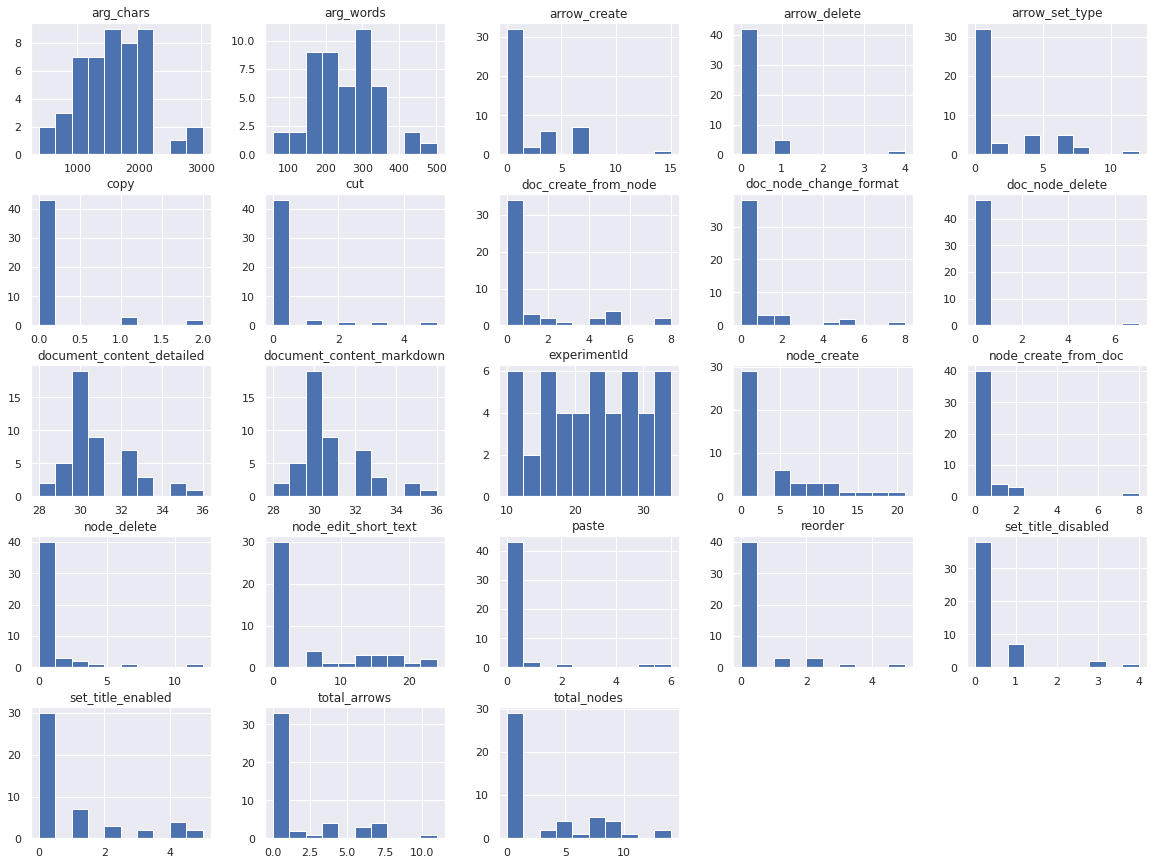

In [20]:
df.hist(figsize=[20, 15]);

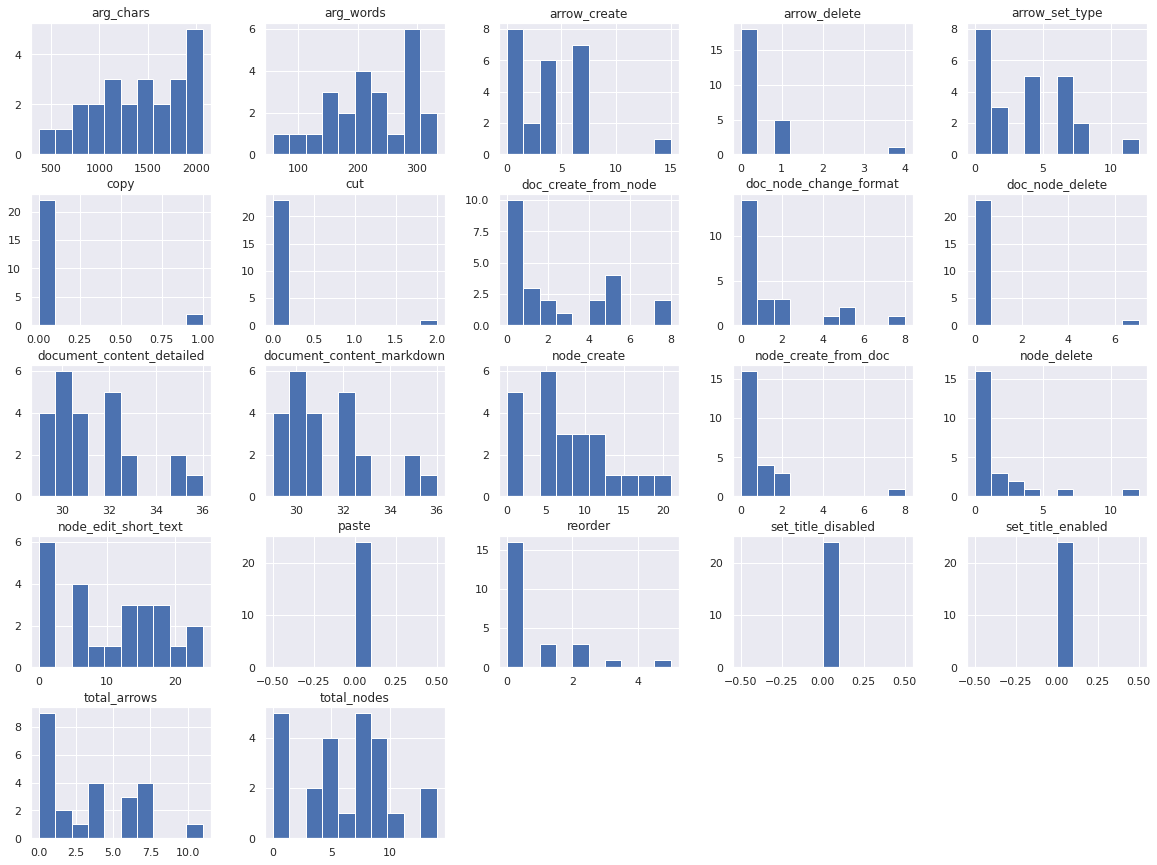

In [13]:
df_graph.hist(figsize=[20, 15]);

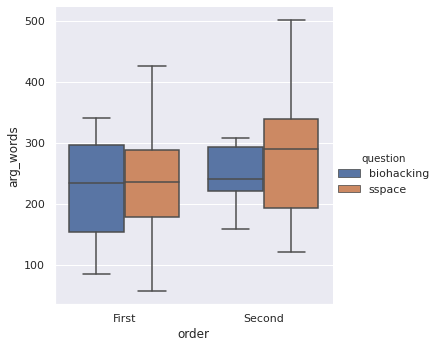

In [77]:
sns.catplot(data=df, x="order", y="arg_words", hue="question", kind="box")

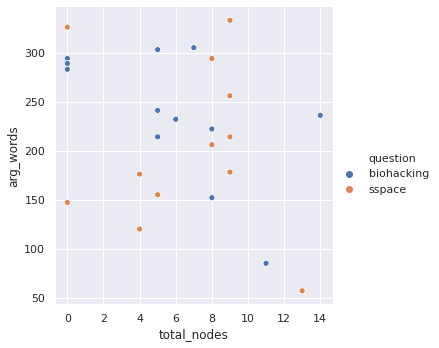

In [16]:
sns.relplot(data=df_graph, x='total_nodes', y='arg_words', hue='question')

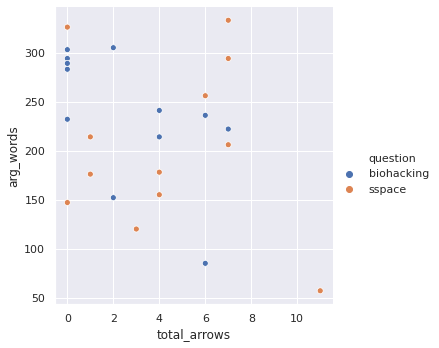

In [17]:
sns.relplot(data=df_graph, x='total_arrows', y='arg_words', hue='question')

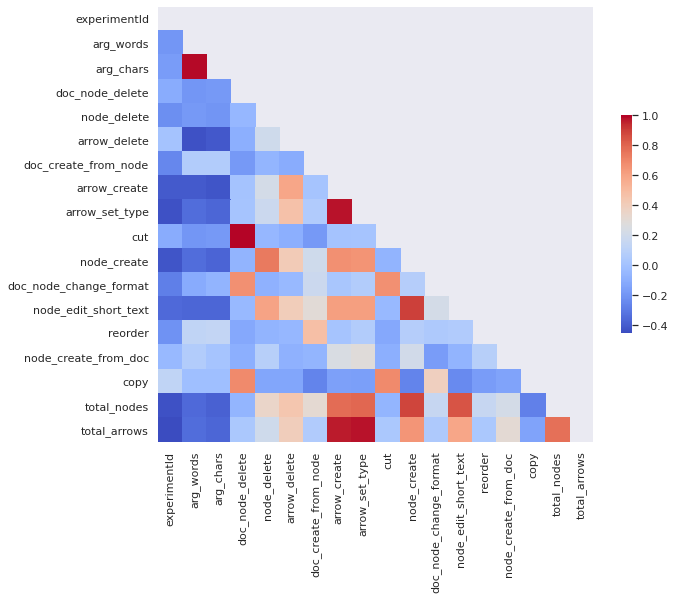

In [23]:
corr = df_graph.drop('set_title_enabled set_title_disabled document_content_markdown document_content_detailed paste'.split(), axis=1).corr()
f, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(round(corr, 2), cmap="coolwarm", square=True, ax=ax, cbar_kws={"shrink": .5}, mask=mask)

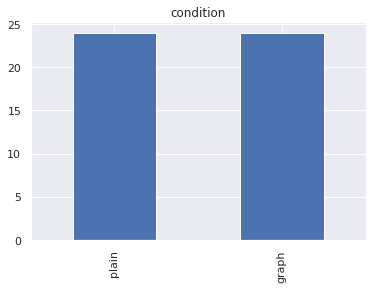

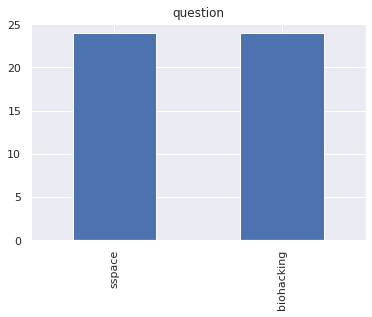

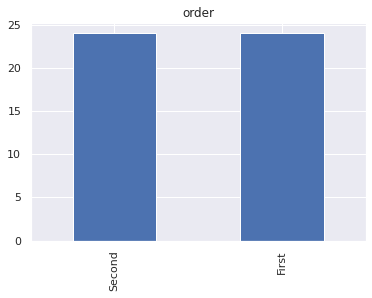

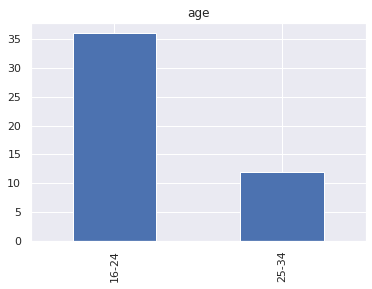

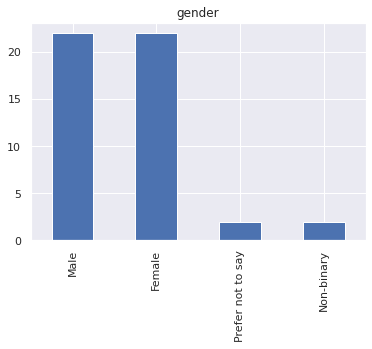

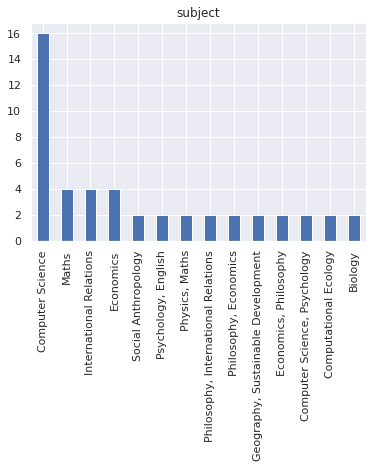

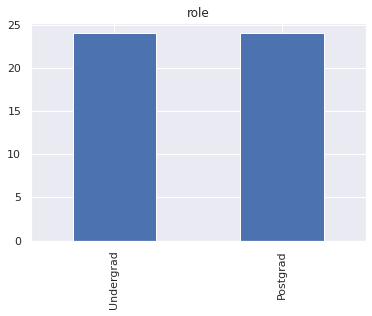

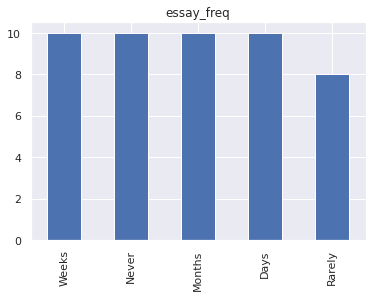

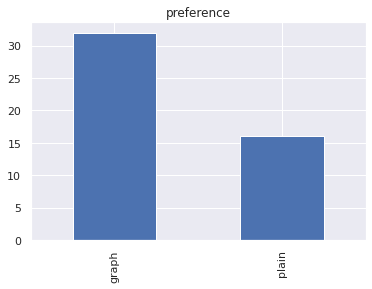

In [61]:
for col in df.select_dtypes(include='category'):
    df[col].value_counts().plot(kind='bar', title=col)
    plt.show()

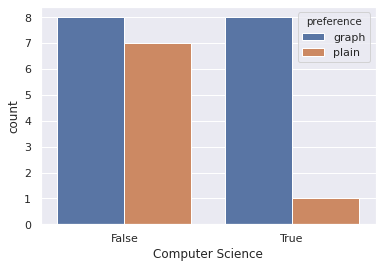

In [105]:
sns.countplot(data=df_graph, x="Computer Science", hue="preference")

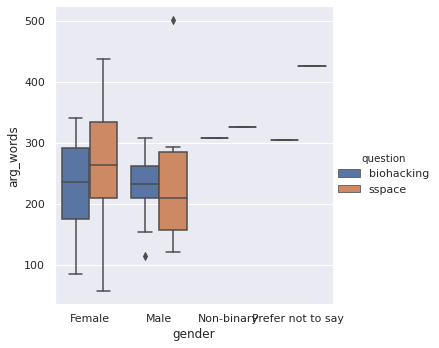

In [63]:
sns.catplot(data=df, x="gender", y="arg_words", hue="question", kind="box")

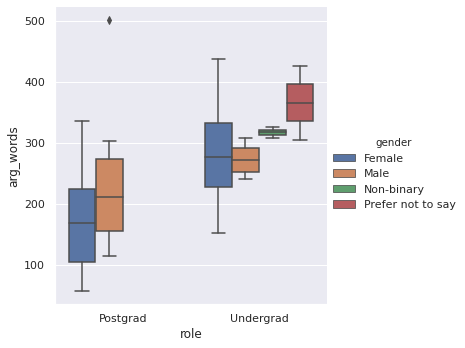

In [28]:
sns.catplot(data=df, x="role", y="arg_words", hue="gender", kind="box")

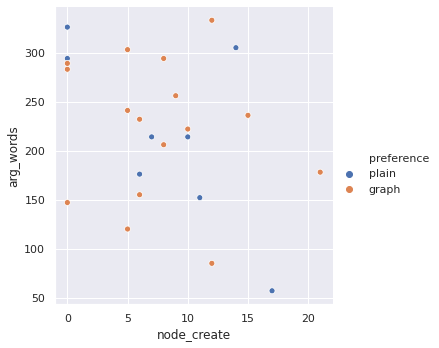

In [76]:
sns.relplot(data=df_graph, x="node_create", y="arg_words", hue="preference")

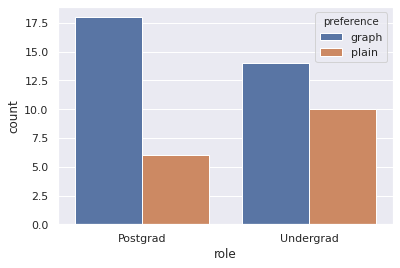

In [85]:
sns.countplot(x="role", hue="preference", data=df)

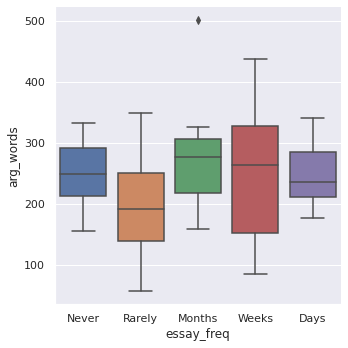

In [110]:
sns.catplot(data=df, x="essay_freq", y="arg_words", kind="box")

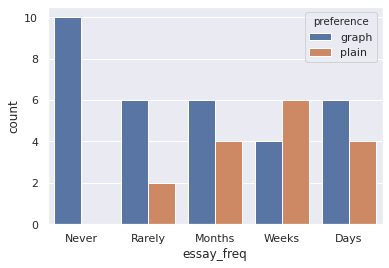

In [111]:
sns.countplot(x="essay_freq", hue="preference", data=df)